Problem 1A. Construct an algorithm for classification of handwritten digits. Use the training set and compute the SVD of each class/digit matrix. Note that in the training set, the first 400 are examples of the digit 0, the next 400 are examples of the digit 1, etc.. Identify the unknown test digits by using the singular value decomposition of each digit matrix. Do the classification using 5, 10, 15 and 20 singular vectors as a basis. 

Loading data...
Raw training data shape: (4000, 400)
Raw test data shape:     (1000, 400)
Unique training labels: [0 1 2 3 4 5 6 7 8 9]
Unique test labels:     [0 1 2 3 4 5 6 7 8 9]

Building class matrices for each digit...
Digit 0: 400 training examples
Digit 1: 400 training examples
Digit 2: 400 training examples
Digit 3: 400 training examples
Digit 4: 400 training examples
Digit 5: 400 training examples
Digit 6: 400 training examples
Digit 7: 400 training examples
Digit 8: 400 training examples
Digit 9: 400 training examples

Computing SVD for each digit class...
Digit 0: U shape = (400, 400), #singular values = 400
Digit 1: U shape = (400, 400), #singular values = 400
Digit 2: U shape = (400, 400), #singular values = 400
Digit 3: U shape = (400, 400), #singular values = 400
Digit 4: U shape = (400, 400), #singular values = 400
Digit 5: U shape = (400, 400), #singular values = 400
Digit 6: U shape = (400, 400), #singular values = 400
Digit 7: U shape = (400, 400), #singular values 

,Number of Basis Vectors (k),Classification Accuracy (%)
0,5,91.8
1,10,94.4
2,15,95.3
3,20,95.7


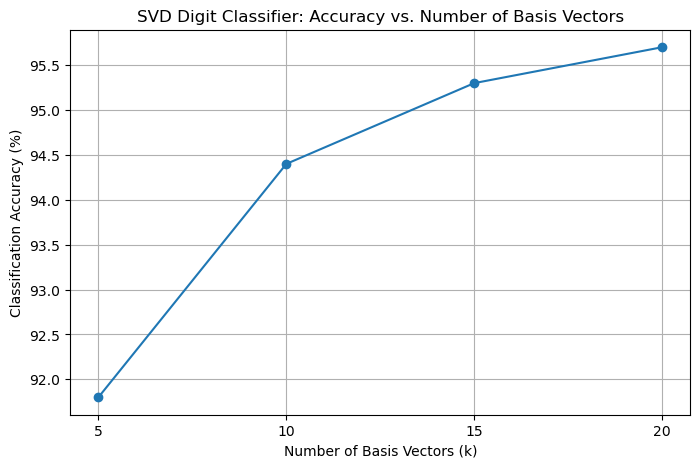

In [2]:
import numpy as np
from numpy.linalg import svd
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import accuracy_score
from IPython.display import display

# Load Data
data_dir = "project2_data"

train_data_path        = f"{data_dir}/handwriting_training_set.txt"
train_labels_path      = f"{data_dir}/handwriting_training_set_labels.txt"
test_data_path         = f"{data_dir}/handwriting_test_set.txt"
test_labels_path       = f"{data_dir}/handwriting_test_set_labels_for_Python.txt"

print("Loading data...")

# Files are comma-separated
training_data = np.loadtxt(train_data_path, delimiter=",")
training_labels = np.loadtxt(train_labels_path, delimiter=",").astype(int)

test_data = np.loadtxt(test_data_path, delimiter=",")
test_labels = np.loadtxt(test_labels_path, delimiter=",").astype(int)

print("Raw training data shape:", training_data.shape)
print("Raw test data shape:    ", test_data.shape)

# Fix labels: 0 is labeled as 10 in the data
training_labels[training_labels == 10] = 0
test_labels[test_labels == 10] = 0

print("Unique training labels:", np.unique(training_labels))
print("Unique test labels:    ", np.unique(test_labels))


# Build class matrices (one matrix per digit 0–9)
print("\nBuilding class matrices for each digit...")

digit_class_matrices = {}  # digit → matrix of its training examples

for digit in range(10):
    digit_indices = np.where(training_labels == digit)[0]
    digit_training_matrix = training_data[digit_indices, :]  # (#examples_for_digit x 400)
    digit_class_matrices[digit] = digit_training_matrix
    print(f"Digit {digit}: {digit_training_matrix.shape[0]} training examples")


# Compute SVD for each digit class
print("\nComputing SVD for each digit class...")

svd_left_singular_vectors = {}  # digit → U matrix (basis vectors in pixel space)

for digit in range(10):
    digit_training_matrix = digit_class_matrices[digit]  # shape: (n_samples, 400)
    
    # Take transpose so columns correspond to images in 400-D pixel space
    # digit_training_matrix.T shape: (400, n_samples)
    U_matrix, singular_values, Vt_matrix = svd(
        digit_training_matrix.T,
        full_matrices=False
    )
    
    svd_left_singular_vectors[digit] = U_matrix  # (400 x r_max)
    print(f"Digit {digit}: U shape = {U_matrix.shape}, #singular values = {singular_values.shape[0]}")

print("SVD computation complete for all digits.")

# Classification function using k basis vectors
def classify_digit(image_vector, num_basis_vectors, svd_bases):
    """
    Classify a single image using SVD subspace projection.
    
    image_vector:       (400,) flattened image
    num_basis_vectors:  k, number of singular vectors (basis vectors) to use
    svd_bases:          dict mapping digit -> U matrix (400 x k)
    """
    reconstruction_errors = []
    
    for digit in range(10):
        U_basis = svd_bases[digit][:, :num_basis_vectors]  # first r basis vectors
        
        # Project image onto the subspace spanned by columns of U_basis
        projection = U_basis @ (U_basis.T @ image_vector)
        
        # Reconstruction error (Euclidean norm)
        error = np.linalg.norm(image_vector - projection)
        reconstruction_errors.append(error)
    
    predicted_digit = np.argmin(reconstruction_errors)
    return predicted_digit

# Classification using k = 5, 10, 15, 20
k_values = [5, 10, 15, 20]
accuracies = {}

print("\nEvaluating classifier for different numbers of basis vectors...\n")

for k in k_values:
    print(f"Using k = {k} basis vectors...")
    predictions = []
    
    for i in range(test_data.shape[0]):
        image_vector = test_data[i, :]
        predicted = classify_digit(image_vector, k, svd_left_singular_vectors)
        predictions.append(predicted)
    
    accuracy = accuracy_score(test_labels, predictions)
    accuracies[k] = accuracy
    print(f"Accuracy for r = {k}: {accuracy:.4f}")

# Table and graph: Accuracy vs # of basis vectors
# Convert accuracies to percentages
accuracy_percentages = {k: 100.0 * acc for k, acc in accuracies.items()}

results_df = pd.DataFrame({
    "Number of Basis Vectors (k)": list(accuracy_percentages.keys()),
    "Classification Accuracy (%)": list(accuracy_percentages.values())
})

print("\nAccuracy table:")
display(results_df)

# Plot accuracy vs number of basis vectors
plt.figure(figsize=(8, 5))
plt.plot(list(accuracy_percentages.keys()),
         list(accuracy_percentages.values()),
         marker='o')
plt.xlabel("Number of Basis Vectors (k)")
plt.ylabel("Classification Accuracy (%)")
plt.title("SVD Digit Classifier: Accuracy vs. Number of Basis Vectors")
plt.grid(True)
plt.xticks(k_values)
plt.show()


Problem 1A i. Give a table or graph of the percentage of correctly classified digits as a function of the number of basis vectors.

In [3]:
from collections import defaultdict

best_k = 20  

# Classify all test images using best_k
predictions = []

for i in range(test_data.shape[0]):
    predictions.append(classify_digit(test_data[i], best_k, svd_left_singular_vectors))

predictions = np.array(predictions)

# Compute per-digit accuracy
digit_correct = defaultdict(int)
digit_total = defaultdict(int)

for true, pred in zip(test_labels, predictions):
    digit_total[true] += 1
    if true == pred:
        digit_correct[true] += 1

digit_accuracy = {d: 100 * digit_correct[d] / digit_total[d] for d in range(10)}

print("Per-digit classification accuracy (%):")
for d in range(10):
    print(f"Digit {d}: {digit_accuracy[d]:.2f}%")


Per-digit classification accuracy (%):
Digit 0: 100.00%
Digit 1: 99.00%
Digit 2: 89.00%
Digit 3: 93.00%
Digit 4: 96.00%
Digit 5: 96.00%
Digit 6: 100.00%
Digit 7: 97.00%
Digit 8: 89.00%
Digit 9: 98.00%


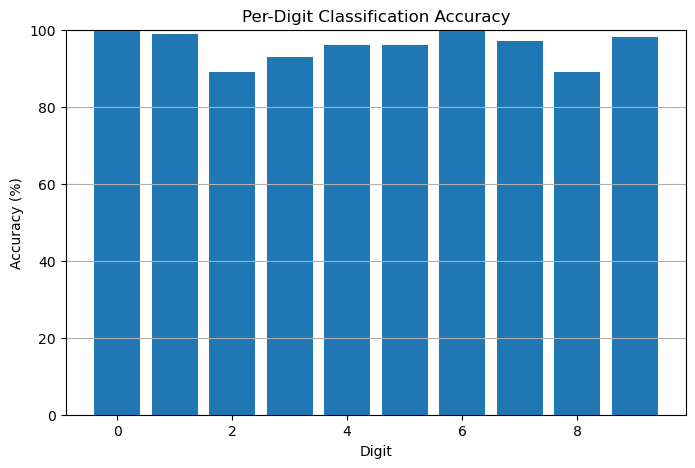

In [4]:
plt.figure(figsize=(8,5))
plt.bar(list(digit_accuracy.keys()), list(digit_accuracy.values()))
plt.xlabel("Digit")
plt.ylabel("Accuracy (%)")
plt.title("Per-Digit Classification Accuracy")
plt.ylim(0, 100)
plt.grid(axis='y')
plt.show()


Problem 1A ii. Check if all digits are equally easy or difficult to classify. Also look at some of the difficult ones, and see that in many cases they are very badly written. 

In [5]:
misclassified_indices = np.where(predictions != test_labels)[0]
print("Number of misclassifications:", len(misclassified_indices))


Number of misclassifications: 43


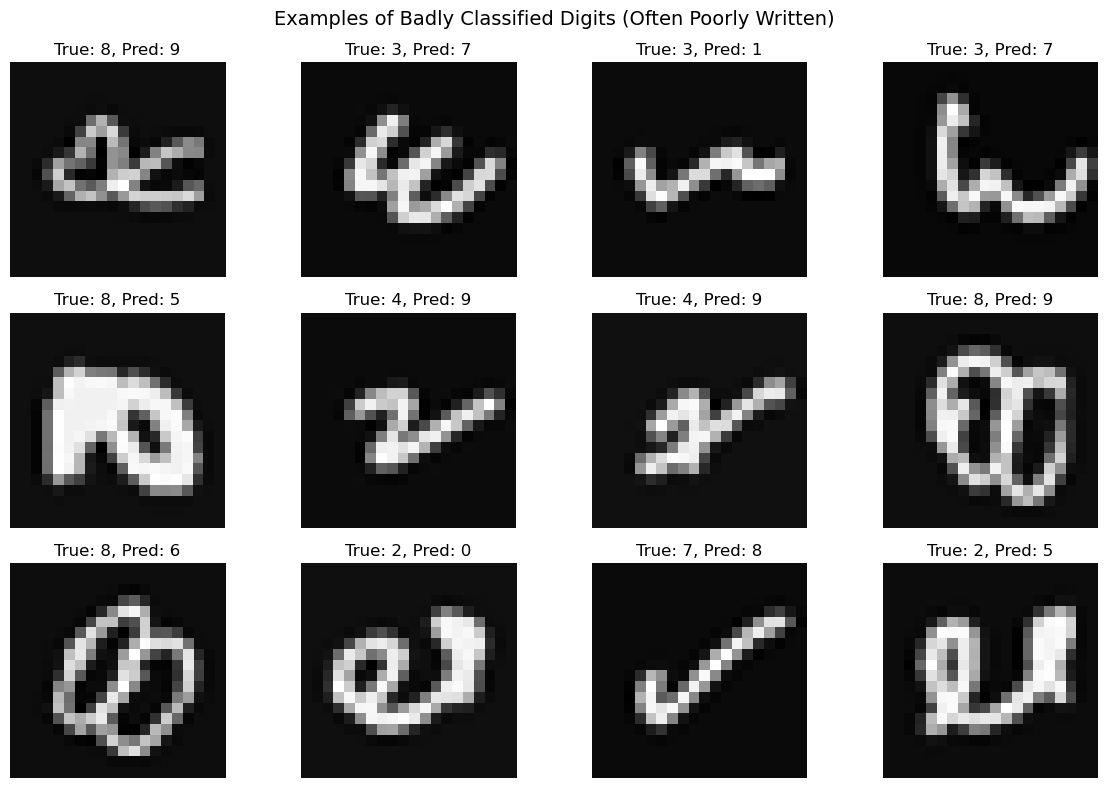

In [6]:
def show_digit(img_vector, title=""):
    img = img_vector.reshape(20, 20)  # because each image is 20×20
    plt.imshow(img, cmap='gray')
    plt.title(title)
    plt.axis('off')

num_to_show = 12
plt.figure(figsize=(12, 8))

for i, idx in enumerate(misclassified_indices[:num_to_show]):
    plt.subplot(3, 4, i+1)
    true_label = test_labels[idx]
    pred_label = predictions[idx]
    show_digit(test_data[idx], title=f"True: {true_label}, Pred: {pred_label}")

plt.suptitle("Examples of Badly Classified Digits (Often Poorly Written)", fontsize=14)
plt.tight_layout()
plt.show()


Problem 1A iii. Check the singular values of the different classes. Is there evidence to support using
different number of basis for different digits?

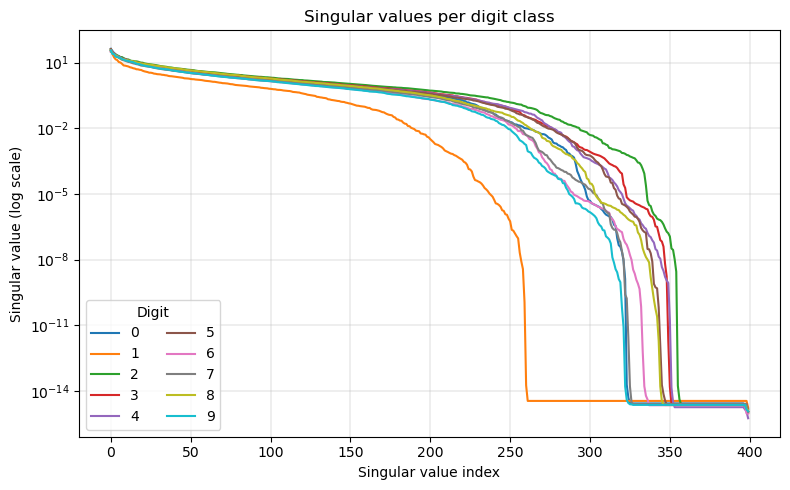

Fraction of energy captured by first k singular values:
Digit 0:
  k =  5: 0.5601
  k = 10: 0.7175
  k = 15: 0.8014
  k = 20: 0.8508

Digit 1:
  k =  5: 0.7370
  k = 10: 0.8393
  k = 15: 0.8891
  k = 20: 0.9200

Digit 2:
  k =  5: 0.4339
  k = 10: 0.6049
  k = 15: 0.6991
  k = 20: 0.7656

Digit 3:
  k =  5: 0.4620
  k = 10: 0.6229
  k = 15: 0.7156
  k = 20: 0.7755

Digit 4:
  k =  5: 0.4543
  k = 10: 0.6401
  k = 15: 0.7334
  k = 20: 0.7924

Digit 5:
  k =  5: 0.4968
  k = 10: 0.6444
  k = 15: 0.7318
  k = 20: 0.7913

Digit 6:
  k =  5: 0.5209
  k = 10: 0.6814
  k = 15: 0.7736
  k = 20: 0.8296

Digit 7:
  k =  5: 0.5425
  k = 10: 0.6967
  k = 15: 0.7790
  k = 20: 0.8301

Digit 8:
  k =  5: 0.4355
  k = 10: 0.5876
  k = 15: 0.6859
  k = 20: 0.7534

Digit 9:
  k =  5: 0.4931
  k = 10: 0.6640
  k = 15: 0.7639
  k = 20: 0.8232



In [ ]:
# Problem A (iii) – Singular values per digit
import numpy as np
import matplotlib.pyplot as plt
# ----------------------------------------------------
X_train_data = training_data   # (n_samples, 400)
y_train_labels = training_labels # (n_samples,)
digits = np.arange(10)   # digits 0–9
ks = [5, 10, 15, 20]     # k values to analyze
# ----------------------------------------------------

# 1. Build a matrix X^(d) for each digit class
digit_indices = {d: np.where(y_train_labels == d)[0] for d in digits}
digit_mats = {d: X_train_data[digit_indices[d], :] for d in digits}

# 2. Compute SVD for each digit class
digit_svd = {}

for d in digits:
    Xd = digit_mats[d]
    Xd_centered = Xd - Xd.mean(axis=0, keepdims=True)
    U, S, Vt = np.linalg.svd(Xd_centered, full_matrices=False)
    digit_svd[d] = {"U": U, "S": S, "Vt": Vt}

# 3. Plot singular values for each digit
plt.figure(figsize=(8, 5))
for d in digits:
    S = digit_svd[d]["S"]
    plt.semilogy(S, label=str(d))  # log-scale to see decay more clearly

plt.xlabel("Singular value index")
plt.ylabel("Singular value (log scale)")
plt.title("Singular values per digit class")
plt.legend(title="Digit", ncol=2)
plt.grid(True, which="both", linewidth=0.3)
plt.tight_layout()
plt.show()

# 4. Compute energy fraction captured by first k singular values
energy = {d: {} for d in digits}

for d in digits:
    S = digit_svd[d]["S"]
    total_energy = np.sum(S**2)
    cum_energy = np.cumsum(S**2)
    for k in ks:
        if k <= len(S):
            energy[d][k] = cum_energy[k-1] / total_energy
        else:
            energy[d][k] = np.nan  # in case k > number of singular values

# 5. Print a small table of energy fractions
print("Fraction of energy captured by first k singular values:")
for d in digits:
    print(f"Digit {d}:")
    for k in ks:
        val = energy[d][k]
        if np.isnan(val):
            print(f"  k = {k:2d}: n/a (k > rank)")
        else:
            print(f"  k = {k:2d}: {val:0.4f}")
    print()



A(iii). For each digit class we computed the SVD of its training matrix and plotted the singular values on a log scale. The curves show noticeable differences between digits. In particular, the singular values for digit 1 decay much faster than for the other digits, while digits such as 0,2,3 and similarly 5,8,9 exhibit a slower decay.

To quantify this, we measured the fraction of energy captured by the first 
𝑘
k singular values. For digit 1 the first 5 modes already capture about 74% of the energy and the first 20 capture about 92%. In contrast, for digits 2 and 3 the first 5 modes capture only about 44–46% and even with 20 modes we are still around 76–78%. Thus some digits are effectively much lower-dimensional than others.

Combining this with the classification results from A(ii), we see that “simple” digits like 1 are already well represented with a small number of basis vectors, and increasing 
𝑘
k does not improve their accuracy as much. More complex digits such as 2,3,5,8,9 benefit more from larger 
𝑘
k. This provides evidence that, in principle, it would be reasonable to use different numbers of basis vectors for different digits, e.g. fewer for digit 1 and more for digits like 2 or 8, instead of a single global 
𝑘
k for all classes.